### English
<img src="https://flagcdn.com/w40/gb.png" width="30">

# Strategy Score: A Quantitative Analysis of the Efficiency of Tire Strategies in Formula 1

**Author:** Marcos Paulo de Oliveira Pereira
<br>
**Date:** August 10, 2025

---

### Português (BR)
<img src="https://flagcdn.com/w40/br.png" width="30">

# Strategy Score: Uma Análise Quantitativa da Eficiência de Estratégias de Pneus na Fórmula 1

**Autor:** Marcos Paulo de Oliveira Pereira
<br>
**Data:** 10 de Agosto de 2025

In [3]:
import fastf1
from fastf1 import plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.ticker import FuncFormatter, MultipleLocator
import json

# --- FastF1 Cache Configuration ---
# Creates a cache directory for FastF1 to store downloaded data, speeding up future loads.
CACHE_DIR = './fastf1_cache'
if not os.path.exists(CACHE_DIR):
    os.makedirs(CACHE_DIR)
fastf1.Cache.enable_cache(CACHE_DIR)
print(f"FastF1 cache enabled at: {os.path.abspath(CACHE_DIR)}")

# --- Base Directory for Processed Data (for saving plots if needed) ---
# This is where generated plots might be stored if plt.savefig() is used.
# The data itself will be loaded directly from FastF1 sessions.
BASE_PLOT_DIR = './f1_plots'
if not os.path.exists(BASE_PLOT_DIR):
    os.makedirs(BASE_PLOT_DIR)
print(f"Base directory for saving plots: {os.path.abspath(BASE_PLOT_DIR)}")


plt.style.use('dark_background') 
COMPOUND_COLORS = fastf1.plotting.COMPOUND_COLORS

FastF1 cache enabled at: c:\Users\mpoli\Desktop\UFOP\8 PERIODO\PAE\Trabalho\fastf1_cache
Base directory for saving plots: c:\Users\mpoli\Desktop\UFOP\8 PERIODO\PAE\Trabalho\f1_plots


C:\Users\mpoli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fastf1\plotting\__init__.py:84: FutureWarning: INCOMPATIBLE with 2025 season! COMPOUND_COLORS is deprecated and will be removed in a future version.
  warnings.warn(f"INCOMPATIBLE with 2025 season! {name} is deprecated "


### English
<img src="https://flagcdn.com/w40/gb.png" width="30">

## 1. Setup and Helper Functions

This cell imports necessary libraries and defines helper functions for data processing and analysis, such as formatting lap times, cleaning lap data, and checking for safety car periods.

---

### Português (BR)
<img src="https://flagcdn.com/w40/br.png" width="30">

## 1. Configuração e Funções de Apoio

Esta célula importa as bibliotecas necessárias e define funções de apoio para o processamento e análise dos dados, como a formatação de tempos de volta, a limpeza de dados das voltas e a verificação de períodos de Safety Car.

In [4]:
import fastf1 as ff1
import pandas as pd
import json

def format_laptime_mmssms(seconds: float) -> str:
    """Formats time in seconds to a MM:SS.ms string."""
    if pd.isna(seconds):
        return ""  # Handle cases where lap time is not available (NaN)
    minutes = int(seconds // 60)
    remaining_seconds = seconds % 60
    return f"{minutes:02d}:{remaining_seconds:06.3f}"

def get_clean_laps(session_laps: pd.DataFrame, target_year: int, race_name: str) -> pd.DataFrame:
    """
    Filters a laps DataFrame to include only accurate laps and ensures the 
    'pirelliCompound' column exists, creating it from a JSON file if needed.
    """
    # Filter for accurate laps. Fastf1's 'IsAccurate' column works well for this.
    # This also excludes first laps, laps with no time, and pit in/out laps.
    clean_laps = session_laps[session_laps['IsAccurate'] == True].copy()
    
    # Check if 'pirelliCompound' column already exists
    if 'pirelliCompound' in clean_laps.columns:
        return clean_laps.reset_index(drop=True)
    else:
        # If not, access the JSON file to map generic compounds (SOFT, MEDIUM, HARD)
        # to specific Pirelli compounds (C1, C2, etc.) for that year and race.
        json_path = 'compounds.json'
        try:
            with open(json_path, 'r') as file:
                compounds_data = json.load(file)
            
            year_str = str(target_year)
            
            if year_str in compounds_data['data']:
                compounds_for_year = compounds_data['data'][year_str]
                gp_compound_mapping = compounds_for_year.get(race_name)

                if gp_compound_mapping:
                    clean_laps['pirelliCompound'] = clean_laps['Compound'].map(gp_compound_mapping)
                    # Fill any non-mapped compounds with their original value
                    clean_laps['pirelliCompound'] = clean_laps['pirelliCompound'].fillna(clean_laps['Compound'])
                    print(f"  'pirelliCompound' column created for {race_name} {target_year}.")
                else:
                    print(f"  Warning: No compound mapping found in JSON for '{race_name}' in year {target_year}. Using original 'Compound' column.")
                    clean_laps['pirelliCompound'] = clean_laps['Compound']
            else:
                print(f"  Warning: Year {target_year} not found in 'compounds.json'. Using original 'Compound' column.")
                clean_laps['pirelliCompound'] = clean_laps['Compound']
        except FileNotFoundError:
            print(f"  Error: 'compounds.json' not found. Using original 'Compound' column.")
            clean_laps['pirelliCompound'] = clean_laps['Compound']
            
    return clean_laps.reset_index(drop=True)


def check_for_safety_car(year: int, gp_name: str) -> bool:
    """
    Checks if a Safety Car or Virtual Safety Car was deployed during a race.
    """
    try:
        session = ff1.get_session(year, gp_name, 'R')
        session.load(telemetry=False, weather=False, messages=True) 

        race_control_messages = session.race_control_messages
        sc_messages = race_control_messages[race_control_messages['Message'].str.contains('SAFETY CAR|VIRTUAL SAFETY CAR')]
        
        if not sc_messages.empty:
            print(f"✅ Safety Car found in: {session.event['EventName']} {year}")
            return True
        else:
            print(f"❌ No Safety Car in: {session.event['EventName']} {year}")
            return False

    except Exception as e:
        print(f"Could not load data for {gp_name} {year}. Error: {e}")
        return None # Return None to indicate an error
    
def get_safety_car_laps(year: int, gp_name: str):
    """
    Retorna uma lista das voltas em que Safety Car ou Virtual Safety Car esteve ativo.
    """
    import fastf1 as ff1
    try:
        session = ff1.get_session(year, gp_name, 'R')
        session.load(telemetry=False, weather=False, messages=True)
        rcm = session.race_control_messages
        sc_laps = rcm[rcm['Message'].str.contains('SAFETY CAR|VIRTUAL SAFETY CAR', case=False, na=False)]['Lap'].dropna().unique().tolist()
        return sorted([int(lap) for lap in sc_laps])
    except Exception as e:
        print(f"Erro ao extrair SC laps para {gp_name} {year}: {e}")
        return []



### English
<img src="https://flagcdn.com/w40/gb.png" width="30">

## 2. Data Collection & Feature Engineering

This cell is the main engine of the project. It iterates through the defined list of years and Grand Prix events, performing a complete data pipeline for each valid race:

1.  **Data Collection:** It uses the `fastf1` library to load session data (laps, results, weather).
2.  **Data Cleaning:** It filters out any race that had wet-weather tires ('INTERMEDIATE' or 'WET') or Safety Car periods to ensure a clean dataset for analysis.
3.  **Feature Engineering:** For each driver, it extracts key features like starting and final positions, number of pit stops, the tire strategy sequence (`Strategy`), and the duration of each stint.
4.  **DataFrame Assembly:** At the end of the loop, all processed data is consolidated into a single master DataFrame (`df_model`) ready for the modeling phase.

---

### Português (BR)
<img src="https://flagcdn.com/w40/br.png" width="30">

## 2. Coleta de Dados e Engenharia de Features

Esta célula é o motor principal do projeto. Ela itera através da lista definida de anos e Grandes Prêmios, realizando um pipeline de dados completo para cada corrida válida:

1.  **Coleta de Dados:** Usa a biblioteca `fastf1` para carregar os dados da sessão (voltas, resultados e meteorologia).
2.  **Limpeza dos Dados:** Filtra qualquer corrida que teve o uso de pneus de chuva ('INTERMEDIATE' ou 'WET') ou períodos de Safety Car, garantindo um conjunto de dados limpo para a análise.
3.  **Engenharia de Features:** Para cada piloto, extrai atributos-chave como as posições de largada e final, o número de paradas, a sequência da estratégia de pneus (`Strategy`) e a duração de cada stint.
4.  **Montagem do DataFrame:** Ao final do loop, todos os dados processados são consolidados em um único DataFrame principal (`df_model`), pronto para a fase de modelagem.

In [5]:
import fastf1
import json
import pandas as pd 
import numpy as np


group_1_gps = [
    "Spanish Grand Prix",
    "Bahrain Grand Prix"
    "British Grand Prix",
    "Japanese Grand Prix",
    "Dutch Grand Prix",
    "Chinese Grand Prix",
    "United States Grand Prix",
]

group_2_gps = [
    "Chinese Grand Prix",
    "French Grand Prix",
    "Austrian Grand Prix",
    "Hungarian Grand Prix",
    "Italian Grand Prix",
    "United States Grand Prix",
    "Mexican Grand Prix",
]



start_year_analysis = 2019
end_year_analysis = 2026

# Initialize a list for feature dictionaries and a dict for weather data
feature_list = []
all_weather_data_by_year = {}

print(f"\n--- Starting Data Collection & Feature Engineering from {start_year_analysis} to {end_year_analysis-1} ---")

for year in range(start_year_analysis, end_year_analysis):
    for target_gp_name in group_1_gps:
        print(f"\n--- Processing {target_gp_name} in Season: {year} ---")
        
        try:
            # --- Session Loading ---
            schedule = fastf1.get_event_schedule(year)
            target_event = schedule[schedule['EventName'].str.contains(target_gp_name, case=False, na=False)]

            if target_event.empty:
                print(f"  Event not found in {year} schedule, skipping.")
                continue

            target_race_round_row = target_event[target_event['EventFormat'].isin(['conventional', 'sprint_shootout', 'sprint'])]
            if target_race_round_row.empty:
                print(f"  Race event not found for {target_gp_name} in {year}, skipping.")
                continue

            round_num = target_race_round_row['RoundNumber'].iloc[0]
            session = fastf1.get_session(year, round_num, 'R') 
            session.load(laps=True, telemetry=False, weather=True, messages=True)

            laps_df = session.laps.copy()
            results_df = session.results.copy()
            
            # --- Data Cleaning & Checks ---
            if laps_df.empty:
                print(f"  No lap data available, skipping.")
                continue

            if 'LapTime_seconds' not in laps_df.columns:
                laps_df['LapTime_seconds'] = laps_df['LapTime'].dt.total_seconds()

            if laps_df['Compound'].isin(['INTERMEDIATE', 'WET']).any():
                print(f"  🌧️ Wet weather tires detected, skipping race.")
                continue
                
            sc_laps = get_safety_car_laps(year, target_gp_name)
            num_sc_laps = len(sc_laps)

            long_sc_period = num_sc_laps > 2

            if long_sc_period:
                print(f"   🚩 Long Safety Car period detected ({num_sc_laps} laps). Flagging race.")

            # --- Data Preparation ---
            json_path = 'compounds.json'
            with open(json_path, 'r') as file:
                compounds_data = json.load(file)
            
            year_str = str(year)
            if year_str in compounds_data['data']:
                gp_compound_mapping = compounds_data['data'][year_str].get(target_gp_name)
                if gp_compound_mapping:
                    laps_df['pirelliCompound'] = laps_df['Compound'].map(gp_compound_mapping)
                    laps_df['pirelliCompound'] = laps_df['pirelliCompound'].fillna(laps_df['Compound'])
                else:
                    laps_df['pirelliCompound'] = laps_df['Compound']
            else:
                laps_df['pirelliCompound'] = laps_df['Compound']
            
            key = (year, target_gp_name)
            all_weather_data_by_year[key] = session.weather_data
            clean_laps_df = get_clean_laps(laps_df, year, target_gp_name)
            print(f"  ✅ Session loaded. Extracting features for {len(laps_df['Driver'].unique())} drivers...")

            for driver in laps_df['Driver'].unique():
                driver_laps = laps_df[laps_df['Driver'] == driver]
                driver_results = results_df[results_df['Abbreviation'] == driver]
                
                if driver_laps.empty or driver_results.empty:
                    continue
                
                finished_statuses = ['Finished', '+1 Lap', '+2 Laps', '+3 Laps', 'Lapped']
                final_position = driver_results['Position'].iloc[0] if driver_results['Status'].iloc[0] in finished_statuses else np.nan
                grid_position = driver_results['GridPosition'].iloc[0]
                points = driver_results['Points'].iloc[0]
                num_stops = driver_laps['Stint'].nunique() - 1
                status = driver_results['Status'].iloc[0]
                
                stints_df = driver_laps.sort_values(by='LapNumber').drop_duplicates(subset='Stint', keep='first')
                compound_sequence = stints_df['pirelliCompound'].tolist()
                strategy_string = '-'.join([str(c) for c in compound_sequence if c is not None])

                features = {
                    'Year': year, 'Race': target_gp_name, 'Driver': driver,
                    'Strategy': strategy_string, 'FinalPosition': final_position,
                    'GridPosition': grid_position, 'NumStops': num_stops, 'Points': points,
                    'Status': status, 'Long_SC_Period': long_sc_period 
                }

                stint_durations = driver_laps.groupby('Stint').size()
                for stint_num, duration in stint_durations.items():
                    features[f'stint_{int(stint_num)}_duration'] = duration

                stint_start_tyre_life = driver_laps.groupby('Stint')['TyreLife'].min().to_dict()
                for stint_num, age in stint_start_tyre_life.items():
                    features[f'stint_{int(stint_num)}_tyre_age'] = age
                    
                feature_list.append(features)

        except Exception as e:
            print(f"  ❌ An error occurred for {target_gp_name} in {year}: {e}")
            continue

# --- Final DataFrame Creation ---
print("\n--- Assembling final DataFrame for modeling ---")
df_model = pd.DataFrame(feature_list)


print("DataFrame for the model created successfully:")
display_cols = ['Year', 'Race', 'Driver', 'Strategy', 'GridPosition', 'FinalPosition'] + \
               sorted([c for c in df_model.columns if 'duration' in c]) + \
               sorted([c for c in df_model.columns if 'tyre_age' in c])
display(df_model[display_cols].head())



--- Starting Data Collection & Feature Engineering from 2019 to 2025 ---

--- Processing Spanish Grand Prix in Season: 2019 ---


core           INFO 	Loading data for Spanish Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.059000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '5', '16', '10', '20', '55', '26', '8', '23', '3', '27', '7', '11', '99', '63', '88', '18', '4']
core           INFO 	Loading data for Spanish Grand Prix - R

  ✅ Session loaded. Extracting features for 20 drivers...

--- Processing Bahrain Grand PrixBritish Grand Prix in Season: 2019 ---
  Event not found in 2019 schedule, skipping.

--- Processing Japanese Grand Prix in Season: 2019 ---


req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 77 completed the race distance 00:00.224000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['77', '5', '44', '23', '55', '16', '10', '11', '18', '26', '4', '7', '8', '99', '20', '63', '88', '33', '3', '27']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data


  ✅ Session loaded. Extracting features for 20 drivers...

--- Processing Dutch Grand Prix in Season: 2019 ---
  Event not found in 2019 schedule, skipping.

--- Processing Chinese Grand Prix in Season: 2019 ---


req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.423000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '5', '33', '16', '10', '3', '11', '7', '23', '8', '18', '20', '55', '99', '63', '88', '4', '26', '27']
core           INFO 	Loading data for Chinese Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_

  ✅ Session loaded. Extracting features for 20 drivers...

--- Processing United States Grand Prix in Season: 2019 ---


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver  4: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 77 completed the race distance 00:00.080000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '33', '16', '23', '3', '4', '55', '27', '11', '7', '26', '18', '99', '8', '10', '63', '20', '88', '5']
core           INFO 	Loading data for United States Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cac

  ✅ Session loaded. Extracting features for 20 drivers...

--- Processing Spanish Grand Prix in Season: 2020 ---


core           INFO 	Loading data for Spanish Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.071000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '18', '11', '55', '5', '23', '10', '4', '3', '26', '31', '7', '20', '99', '63', '6', '8', '16']
core           INFO 	Loading data for Spanish Grand Prix - Ra

  ✅ Session loaded. Extracting features for 20 drivers...

--- Processing Bahrain Grand PrixBritish Grand Prix in Season: 2020 ---
  Event not found in 2020 schedule, skipping.

--- Processing Japanese Grand Prix in Season: 2020 ---
  Event not found in 2020 schedule, skipping.

--- Processing Dutch Grand Prix in Season: 2020 ---
  Event not found in 2020 schedule, skipping.

--- Processing Chinese Grand Prix in Season: 2020 ---
  Event not found in 2020 schedule, skipping.

--- Processing United States Grand Prix in Season: 2020 ---
  Event not found in 2020 schedule, skipping.

--- Processing Spanish Grand Prix in Season: 2021 ---


core           INFO 	Loading data for Spanish Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.083000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '16', '11', '3', '55', '4', '31', '10', '18', '7', '5', '63', '99', '6', '14', '47', '9', '22']
core           INFO 	Loading data for Spanish Grand Prix - Ra

  ✅ Session loaded. Extracting features for 20 drivers...

--- Processing Bahrain Grand PrixBritish Grand Prix in Season: 2021 ---
  Event not found in 2021 schedule, skipping.

--- Processing Japanese Grand Prix in Season: 2021 ---
  Event not found in 2021 schedule, skipping.

--- Processing Dutch Grand Prix in Season: 2021 ---


req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.012000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '77', '10', '16', '14', '55', '11', '31', '4', '3', '18', '5', '99', '88', '6', '63', '47', '22', '9']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req      

  ✅ Session loaded. Extracting features for 20 drivers...

--- Processing Chinese Grand Prix in Season: 2021 ---
  Event not found in 2021 schedule, skipping.

--- Processing United States Grand Prix in Season: 2021 ---


core        WARNING 	Driver  7: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.059000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '11', '16', '3', '77', '55', '4', '22', '5', '99', '18', '7', '63', '6', '47', '9', '14', '31', '10']
core           INFO 	Loading data for United States Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Pr

  ✅ Session loaded. Extracting features for 20 drivers...

--- Processing Spanish Grand Prix in Season: 2022 ---


core           INFO 	Loading data for Spanish Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '63', '55', '44', '77', '31', '4', '14', '22', '5', '3', '10', '47', '18', '6', '20', '23', '24', '16']
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for 

  ✅ Session loaded. Extracting features for 20 drivers...

--- Processing Bahrain Grand PrixBritish Grand Prix in Season: 2022 ---
  Event not found in 2022 schedule, skipping.

--- Processing Japanese Grand Prix in Season: 2022 ---


req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '31', '44', '5', '14', '63', '6', '4', '3', '18', '22', '20', '77', '24', '47', '10', '55', '23']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


  🌧️ Wet weather tires detected, skipping race.

--- Processing Dutch Grand Prix in Season: 2022 ---


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '63', '16', '44', '11', '14', '4', '55', '31', '18', '10', '23', '47', '5', '20', '24', '3', '6', '77', '22']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '63', '16', '44', '11', '14', '4', '55', '31

   🚩 Long Safety Car period detected (7 laps). Flagging race.
  ✅ Session loaded. Extracting features for 20 drivers...

--- Processing Chinese Grand Prix in Season: 2022 ---
  Event not found in 2022 schedule, skipping.

--- Processing United States Grand Prix in Season: 2022 ---


req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '16', '11', '63', '4', '14', '5', '20', '22', '31', '24', '23', '10', '47', '3', '6', '18', '77', '55']
events      WARNING 	Correcting user input 'United States Grand Prix' to 'United States Grand Prix'
core           INFO 	Loading data for United States Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req          

   🚩 Long Safety Car period detected (7 laps). Flagging race.
  ✅ Session loaded. Extracting features for 20 drivers...

--- Processing Spanish Grand Prix in Season: 2023 ---


core           INFO 	Loading data for Spanish Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.037000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '11', '55', '18', '14', '31', '24', '10', '16', '22', '81', '21', '27', '23', '4', '20', '77', '2']
core           INFO 	Loading data for Spanish Grand Prix - 

  ✅ Session loaded. Extracting features for 20 drivers...

--- Processing Bahrain Grand PrixBritish Grand Prix in Season: 2023 ---
  Event not found in 2023 schedule, skipping.

--- Processing Japanese Grand Prix in Season: 2023 ---


req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.076000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '44', '55', '63', '14', '31', '10', '40', '22', '24', '27', '20', '23', '2', '18', '11', '77']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req  

   🚩 Long Safety Car period detected (5 laps). Flagging race.
  ✅ Session loaded. Extracting features for 20 drivers...

--- Processing Dutch Grand Prix in Season: 2023 ---


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:02.059000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '10', '11', '55', '44', '4', '23', '81', '31', '18', '27', '40', '77', '22', '20', '63', '24', '16', '2']
core           INFO 	Loading data for United States Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


  🌧️ Wet weather tires detected, skipping race.

--- Processing Chinese Grand Prix in Season: 2023 ---
  Event not found in 2023 schedule, skipping.

--- Processing United States Grand Prix in Season: 2023 ---


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '55', '11', '63', '10', '18', '22', '23', '2', '27', '77', '24', '20', '3', '14', '81', '31', '44', '16']
events      WARNING 	Correcting user input 'United States Grand Prix' to 'United States Grand Prix'
core           INFO 	Loading data for United States Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages


  ✅ Session loaded. Extracting features for 20 drivers...

--- Processing Spanish Grand Prix in Season: 2024 ---


core           INFO 	Loading data for Spanish Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.015000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '44', '63', '16', '55', '81', '11', '10', '31', '27', '14', '24', '18', '3', '77', '20', '23', '22', '2']
core           INFO 	Loading data for Spanish Grand Prix - R

  ✅ Session loaded. Extracting features for 20 drivers...

--- Processing Bahrain Grand PrixBritish Grand Prix in Season: 2024 ---
  Event not found in 2024 schedule, skipping.

--- Processing Japanese Grand Prix in Season: 2024 ---


req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '4', '14', '63', '81', '44', '22', '27', '18', '20', '77', '31', '10', '2', '24', '3', '23']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages

  ✅ Session loaded. Extracting features for 20 drivers...

--- Processing Dutch Grand Prix in Season: 2024 ---


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '16', '81', '55', '11', '63', '44', '10', '14', '27', '3', '18', '23', '31', '2', '22', '20', '77', '24']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '16', '81', '55', '11', '63', '44', '1

  ✅ Session loaded. Extracting features for 20 drivers...

--- Processing Chinese Grand Prix in Season: 2024 ---
  Race event not found for Chinese Grand Prix in 2024, skipping.

--- Processing United States Grand Prix in Season: 2024 ---
  Race event not found for United States Grand Prix in 2024, skipping.

--- Processing Spanish Grand Prix in Season: 2025 ---


core           INFO 	Loading data for Spanish Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 19 drivers: ['81', '4', '16', '63', '27', '44', '6', '10', '14', '1', '30', '5', '22', '55', '43', '31', '87', '12', '23']
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for drive

   🚩 Long Safety Car period detected (3 laps). Flagging race.
  ✅ Session loaded. Extracting features for 19 drivers...

--- Processing Bahrain Grand PrixBritish Grand Prix in Season: 2025 ---
  Event not found in 2025 schedule, skipping.

--- Processing Japanese Grand Prix in Season: 2025 ---


req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '63', '12', '44', '6', '23', '87', '14', '22', '10', '55', '7', '27', '30', '31', '5', '18']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages


  ✅ Session loaded. Extracting features for 20 drivers...

--- Processing Dutch Grand Prix in Season: 2025 ---


logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
logger      WARNING 	Failed to load total lap count!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
logger      WARNING 	Failed to load track status data!
req            INFO 	No 

  ❌ An error occurred for Dutch Grand Prix in 2025: The data you are trying to access has not been loaded yet. See `Session.load`

--- Processing Chinese Grand Prix in Season: 2025 ---
  Race event not found for Chinese Grand Prix in 2025, skipping.

--- Processing United States Grand Prix in Season: 2025 ---
  Race event not found for United States Grand Prix in 2025, skipping.

--- Assembling final DataFrame for modeling ---
DataFrame for the model created successfully:


,Year,Race,Driver,Strategy,GridPosition,FinalPosition,stint_1_duration,stint_2_duration,stint_3_duration,stint_4_duration,stint_5_duration,stint_6_duration,stint_1_tyre_age,stint_2_tyre_age,stint_3_tyre_age,stint_4_tyre_age,stint_5_tyre_age,stint_6_tyre_age
0,2019,Spanish Grand Prix,GAS,C3-C2-C3,6.0,6.0,22,24.0,20.0,NaN,NaN,NaN,4.0,1.0,4.0,NaN,NaN,NaN
1,2019,Spanish Grand Prix,PER,C3-C2-C3,15.0,15.0,24,21.0,21.0,NaN,NaN,NaN,1.0,1.0,4.0,NaN,NaN,NaN
2,2019,Spanish Grand Prix,LEC,C3-C1-C2,5.0,5.0,25,21.0,20.0,NaN,NaN,NaN,4.0,1.0,1.0,NaN,NaN,NaN
3,2019,Spanish Grand Prix,STR,C2-C3,16.0,NaN,22,23.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
4,2019,Spanish Grand Prix,MAG,C3-C2-C3,8.0,7.0,23,22.0,21.0,NaN,NaN,NaN,4.0,1.0,4.0,NaN,NaN,NaN


### English
<img src="https://flagcdn.com/w40/gb.png" width="30">

## 3. Model Preparation and Fitting (OLS Regression)

This cell prepares the data for regression analysis and fits an Ordinary Least Squares (OLS) model using the `statsmodels` library.

**Steps:**
1.  **Create Target Variable (`Strategy_Score`)**: A custom score is engineered to evaluate strategy effectiveness. It gives points for each driver that finished the race, from the last to the first
2.  **Merge Weather Data**: Average weather conditions (Air Temp, Track Temp, etc.) are merged into the main DataFrame.
3.  **Feature Engineering**: The `Strategy` string is split into separate columns for each stint's compound.
4.  **Prepare Data for Model**: Features (`X`) and the target (`y`) are defined. Categorical features are converted to dummy variables.
5.  **Fit OLS Model**: A linear regression model is fitted to predict the `Strategy_Score`.
6.  **Display Summary**: The statistical summary of the model is printed, showing coefficients, R-squared, p-values, etc.

---

### Português (BR)
<img src="https://flagcdn.com/w40/br.png" width="30">

## 3. Preparação e Treinamento do Modelo (Regressão OLS)

Esta célula prepara os dados para a análise de regressão e treina um modelo de Mínimos Quadrados Ordinários (OLS) usando a biblioteca `statsmodels`.

**Passos:**
1.  **Criação da Variável Alvo (`Strategy_Score`)**: Uma pontuação customizada é criada para avaliar a eficácia da estratégia, conferindo pontos para todos que finalizaram a corrida.
2.  **União com Dados Meteorológicos**: As condições meteorológicas médias (Temp. do Ar, Temp. da Pista, etc.) são unidas ao DataFrame principal.
3.  **Engenharia de Atributos**: A string `Strategy` é dividida em colunas separadas para o composto de cada stint.
4.  **Preparação dos Dados para o Modelo**: As features (`X`) e a variável alvo (`y`) são definidas. As features categóricas são convertidas em variáveis dummy.
5.  **Treinamento do Modelo OLS**: Um modelo de regressão linear é treinado para prever o `Strategy_Score`.
6.  **Exibição do Sumário**: O sumário estatístico do modelo é exibido, mostrando os coeficientes, R-squared, p-valores, etc.

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.linear_model import Ridge

import statsmodels.api as sm

print("--- Calculating new Strategy_Score based on historical expectation ---")



df_model['FinalPosition'] = pd.to_numeric(df_model['FinalPosition'], errors='coerce')
# Pitlane
df_model.loc[df_model['GridPosition'] == 0, 'GridPosition'] = 21
print("--- Calculating new rank-based Strategy_Score ---")

df_model['Race_Rank'] = df_model.groupby(['Year', 'Race'])['FinalPosition'].rank(method='dense', ascending=True)
df_model['Num_Finishers'] = df_model.groupby(['Year', 'Race'])['Race_Rank'].transform('max')
df_model['Positions_Gained_Lost'] = df_model['GridPosition'] - df_model['FinalPosition']
df_model['Strategy_Score'] = ((df_model['Num_Finishers'] + 1) - df_model['Race_Rank']) + 0.5*df_model['Points'] + 0.1*df_model['Positions_Gained_Lost']
df_model.drop(columns=['Race_Rank', 'Num_Finishers'], inplace=True)

print("Rank-based Strategy_Score created successfully.")

weather_rows = []

for (year, race), weather_data in all_weather_data_by_year.items():

    weather_rows.append({

        'Year': year,      

        'Race': race,  

        'AirTemp': weather_data['AirTemp'].mean().round(2),

        'WindSpeed': weather_data['WindSpeed'].mean().round(2),

        'TrackTemp': weather_data['TrackTemp'].mean().round(2),

        'Humidity': weather_data['Humidity'].mean().round(2),

        'Pressure': weather_data['Pressure'].mean().round(2)

    })


df_weather = pd.DataFrame(weather_rows)
df_model_final = pd.merge(df_model, df_weather, on=['Year', 'Race'], how='left')

compound_list = df_model_final['Strategy'].str.split('-')

df_model_final['start_compound'] = compound_list.str.get(0)
df_model_final['second_stint_compound'] = compound_list.str.get(1)
df_model_final['third_stint_compound'] = compound_list.str.get(2)
df_model_final['fourth_stint_compound'] = compound_list.str.get(3)
df_model_final['fifth_stint_compound'] = compound_list.str.get(4)




finished_flags = ['Finished', '+1 Lap', '+2 Laps', '+3 Laps', 'Lapped']

df_model_final = df_model_final[df_model_final['Status'].isin(finished_flags)]


df_model_final.fillna({

    'second_stint_compound': 'None',

    'third_stint_compound': 'None',

    'fourth_stint_compound': 'None',

    'fifth_stint_compound': 'None',

    'stint_2_duration': 0,

    'stint_3_duration': 0,

    'stint_4_duration': 0,

    'stint_5_duration': 0,

}, inplace=True)


df_model_final['Long_SC_Period'] = df_model_final['Long_SC_Period'].astype(float)

# Filtering races that are interrupted by SC for a long period of time

df_model_final = df_model_final[df_model_final['Long_SC_Period'] == 0.0]


strategy_counts = df_model_final.groupby(['Year', 'Race', 'Strategy']).size().reset_index(name='Usage_Count')


top_5_strategies_per_race = strategy_counts.groupby(['Year', 'Race']).apply(

    lambda x: x.nlargest(8, 'Usage_Count')

).reset_index(drop=True)


print("Exemplo das Top 5 estratégias mais comuns para algumas corridas:")


df_top5_strategies_only = pd.merge(

    df_model_final,

    top_5_strategies_per_race[['Year', 'Race', 'Strategy']],

    on=['Year', 'Race', 'Strategy'],

    how='inner'

)

display(df_top5_strategies_only)


print(f"\nFiltragem concluída.")

print(f"O DataFrame original tinha {len(df_model_final)} linhas.")

print(f"O novo DataFrame focado nas Top 5 estratégias tem {len(df_top5_strategies_only)} linhas.")


print("\nVerificação: Contagem de estratégias únicas por corrida no DataFrame filtrado:")

duration_cols = [f'stint_{i}_duration' for i in range(1, 6) if f'stint_{i}_duration' in df_top5_strategies_only.columns]
df_top5_strategies_only['TotalLaps'] = df_top5_strategies_only[duration_cols].sum(axis=1)


target = 'Strategy_Score'

numerical_features = [
    'GridPosition', 'TrackTemp', 'WindSpeed'
]
categorical_features = ['start_compound', 'second_stint_compound', 'third_stint_compound', 'fourth_stint_compound', 'Race']

model_df = df_top5_strategies_only[numerical_features + categorical_features + [target]].dropna().copy()

X = model_df.drop(columns=target)
y = model_df[target]

X_dummies = pd.get_dummies(X[categorical_features], drop_first=True, dtype=float)
X_processed = pd.concat([X[numerical_features], X_dummies], axis=1)

X_with_constant = sm.add_constant(X_processed)

model = sm.OLS(y, X_with_constant)
results = model.fit()

print("\n--- Full Statistical Summary (Modelo com Características de Pista) ---")
print(results.summary())

--- Calculating new Strategy_Score based on historical expectation ---
--- Calculating new rank-based Strategy_Score ---
Rank-based Strategy_Score created successfully.
Exemplo das Top 5 estratégias mais comuns para algumas corridas:


C:\Users\mpoli\AppData\Local\Temp\ipykernel_8992\1015544636.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_strategies_per_race = strategy_counts.groupby(['Year', 'Race']).apply(


,Year,Race,Driver,Strategy,FinalPosition,GridPosition,NumStops,Points,Status,Long_SC_Period,...,AirTemp,WindSpeed,TrackTemp,Humidity,Pressure,start_compound,second_stint_compound,third_stint_compound,fourth_stint_compound,fifth_stint_compound
0,2019,Spanish Grand Prix,GAS,C3-C2-C3,6.0,6.0,2,8.0,Finished,0.0,...,20.15,1.93,40.73,54.72,1006.79,C3,C2,C3,None,None
1,2019,Spanish Grand Prix,PER,C3-C2-C3,15.0,15.0,2,0.0,Finished,0.0,...,20.15,1.93,40.73,54.72,1006.79,C3,C2,C3,None,None
2,2019,Spanish Grand Prix,LEC,C3-C1-C2,5.0,5.0,2,10.0,Finished,0.0,...,20.15,1.93,40.73,54.72,1006.79,C3,C1,C2,None,None
3,2019,Spanish Grand Prix,MAG,C3-C2-C3,7.0,8.0,2,6.0,Finished,0.0,...,20.15,1.93,40.73,54.72,1006.79,C3,C2,C3,None,None
4,2019,Spanish Grand Prix,ALB,C3-C2-C2,11.0,11.0,2,0.0,Finished,0.0,...,20.15,1.93,40.73,54.72,1006.79,C3,C2,C2,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,2025,Japanese Grand Prix,HUL,C2-C1,16.0,16.0,1,0.0,Finished,0.0,...,14.43,1.20,20.51,76.37,1009.32,C2,C1,None,None,None
258,2025,Japanese Grand Prix,LAW,C2-C3,17.0,13.0,1,0.0,Finished,0.0,...,14.43,1.20,20.51,76.37,1009.32,C2,C3,None,None,None
259,2025,Japanese Grand Prix,OCO,C1-C2,18.0,18.0,1,0.0,Finished,0.0,...,14.43,1.20,20.51,76.37,1009.32,C1,C2,None,None,None
260,2025,Japanese Grand Prix,BOR,C1-C2,19.0,17.0,1,0.0,Finished,0.0,...,14.43,1.20,20.51,76.37,1009.32,C1,C2,None,None,None



Filtragem concluída.
O DataFrame original tinha 270 linhas.
O novo DataFrame focado nas Top 5 estratégias tem 262 linhas.

Verificação: Contagem de estratégias únicas por corrida no DataFrame filtrado:


,GridPosition,TrackTemp,WindSpeed,start_compound,second_stint_compound,third_stint_compound,fourth_stint_compound,Race,Strategy_Score
0,6.0,40.73,1.93,C3,C2,C3,None,Spanish Grand Prix,17.0
1,15.0,40.73,1.93,C3,C2,C3,None,Spanish Grand Prix,4.0
2,5.0,40.73,1.93,C3,C1,C2,None,Spanish Grand Prix,19.0
3,8.0,40.73,1.93,C3,C2,C3,None,Spanish Grand Prix,15.1
4,11.0,40.73,1.93,C3,C2,C2,None,Spanish Grand Prix,8.0
...,...,...,...,...,...,...,...,...,...
257,16.0,20.51,1.20,C2,C1,None,None,Japanese Grand Prix,5.0
258,13.0,20.51,1.20,C2,C3,None,None,Japanese Grand Prix,3.6
259,18.0,20.51,1.20,C1,C2,None,None,Japanese Grand Prix,3.0
260,17.0,20.51,1.20,C1,C2,None,None,Japanese Grand Prix,1.8



--- Full Statistical Summary (Modelo com Características de Pista) ---
                            OLS Regression Results                            
Dep. Variable:         Strategy_Score   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     34.77
Date:                qua, 20 ago 2025   Prob (F-statistic):           1.39e-59
Time:                        10:37:10   Log-Likelihood:                -759.50
No. Observations:                 262   AIC:                             1561.
Df Residuals:                     241   BIC:                             1636.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

### English
<img src="https://flagcdn.com/w40/gb.png" width="30">

## 4. Regression Diagnostics & Assumption Checks

This cell contains a library of functions to perform diagnostic checks on the fitted OLS model. It tests the key assumptions of linear regression:

1.  **Linearity**: Checks if the relationship between predicted and actual values is linear.
2.  **Independence of Residuals**: Checks for autocorrelation using scatter plots and the Durbin-Watson test.
3.  **Normality of Residuals**: Checks if the errors are normally distributed using statistical tests (Jarque-Bera) and a Q-Q plot.
4.  **Homoscedasticity (Constant Variance)**: Checks if the variance of the residuals is constant across all predicted values.

---

### Português (BR)
<img src="https://flagcdn.com/w40/br.png" width="30">

## 4. Diagnóstico da Regressão e Verificação das Premissas

Esta célula contém um conjunto de funções para realizar verificações de diagnóstico no modelo OLS treinado. Ela testa as principais premissas da regressão linear:

1.  **Linearidade**: Verifica se a relação entre os valores previstos e os valores reais é linear.
2.  **Independência dos Resíduos**: Verifica a existência de autocorrelação usando gráficos de dispersão e o teste de Durbin-Watson.
3.  **Normalidade dos Resíduos**: Verifica se os erros seguem uma distribuição normal usando testes estatísticos (Jarque-Bera) e um gráfico Q-Q.
4.  **Homocedasticidade (Variância Constante)**: Verifica se a variância dos resíduos é constante para todos os níveis dos valores previstos.

Assumption 1: Linear relationship between actual and predicted values



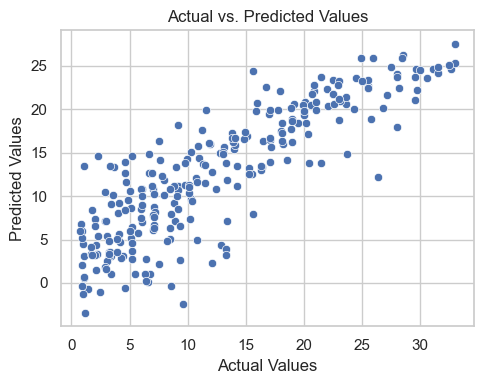

Assumption 2: Independence of residuals

Scatter plot of residuals vs. observation order


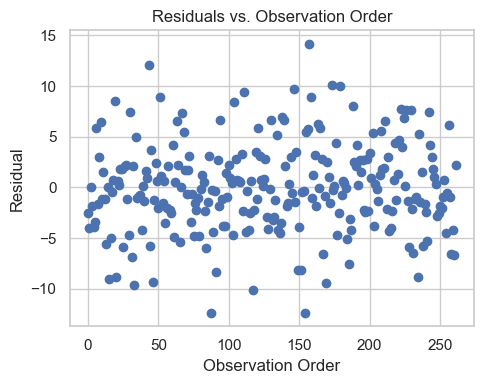

Computing the Durbin-Watson test for autocorrelation
Durbin-Watson statistic: 2.03
Little to no evidence of first-order autocorrelation. Assumption is likely met.

Assumption 3: Normality of residuals

Using the Jarque-Bera test for normality
Jarque-Bera P-value: 0.3760
The null hypothesis (residuals are normally distributed) cannot be rejected. Assumption is met.

Plotting a Q-Q plot to visually inspect normality


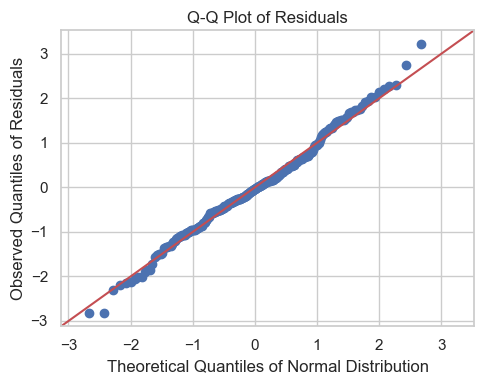


Assumption 4: Homoscedasticity of residuals (constant variance)



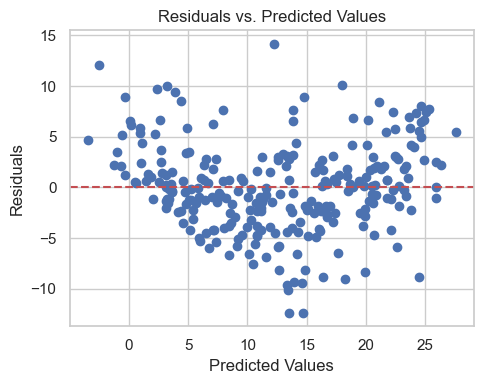

Visually inspect the plot. If residuals form a cone shape or a clear pattern, heteroscedasticity is present.


,actual,predicted,residual
0,17.0,19.512599,-2.512599
1,4.0,8.043659,-4.043659
2,19.0,18.912621,0.087379
3,15.1,16.963946,-1.863946
4,8.0,11.874437,-3.874437
...,...,...,...
257,5.0,5.934926,-0.934926
258,3.6,10.163784,-6.563784
259,3.0,7.162335,-4.162335
260,1.8,8.436661,-6.636661


--- Top 5 Outliers Negativos (Pontos mais baixos no gráfico) ---


,Year,Race,Driver,Strategy,GridPosition,FinalPosition,Strategy_Score,predicted_score,residual
154,2022,Spanish Grand Prix,MAG,C3-C2-C1,8.0,17.0,1.1,13.470929,-12.370929
87,2021,Spanish Grand Prix,ALO,C3-C2-C3,10.0,17.0,2.3,14.651055,-12.351055
117,2021,Dutch Grand Prix,GIO,C3-C2-C1,7.0,14.0,3.3,13.420795,-10.120795
33,2019,Japanese Grand Prix,GIO,C2-C1-C3,11.0,14.0,3.7,13.333097,-9.633097
169,2023,Spanish Grand Prix,HUL,C3-C2-C1-C2,7.0,15.0,5.2,14.630187,-9.430187


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson, jarque_bera
import scipy.stats

# --- Setup ---
sns.set(style="whitegrid")

# Create a DataFrame from the model results for easier diagnostics
results_df = pd.DataFrame({
    'actual': y,
    'predicted': results.fittedvalues,
    'residual': results.resid
}).reset_index(drop=True)


# --- Diagnostic Functions ---

def check_linearity(df_results: pd.DataFrame):
    """Checks the linearity assumption between actual and predicted values."""
    print('Assumption 1: Linear relationship between actual and predicted values\n')
    plt.figure(figsize=(5, 4))
    sns.scatterplot(x='actual', y='predicted', data=df_results)
    plt.title('Actual vs. Predicted Values')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.tight_layout()  
    plt.show()

def check_independence(df_results: pd.DataFrame):
    """Checks the independence of residuals assumption."""
    print('Assumption 2: Independence of residuals\n')
    
    print("Scatter plot of residuals vs. observation order")
    plt.figure(figsize=(5, 4))
    plt.scatter(x=df_results.index, y=df_results['residual'])
    plt.title("Residuals vs. Observation Order")
    plt.xlabel("Observation Order")
    plt.ylabel("Residual")
    plt.tight_layout()
    plt.show()

    print('Computing the Durbin-Watson test for autocorrelation')
    durbinWatson = durbin_watson(df_results['residual'])
    print(f'Durbin-Watson statistic: {durbinWatson:.2f}')
    if durbinWatson < 1.5:
        print('Indicates positive autocorrelation. Assumption may not be met.')
    elif durbinWatson > 2.5:
        print('Indicates negative autocorrelation. Assumption may not be met.')
    else:
        print('Little to no evidence of first-order autocorrelation. Assumption is likely met.')

def check_error_normality(df_results: pd.DataFrame, p_value_thresh=0.05):
    """Checks the normality of residuals assumption using tests and a Q-Q plot."""
    print('\nAssumption 3: Normality of residuals\n')
    
    print('Using the Jarque-Bera test for normality')
    jb_stat, p_value, _, _ = jarque_bera(df_results['residual'])
    print(f"Jarque-Bera P-value: {p_value:.4f}")
    if p_value > p_value_thresh:
        print('The null hypothesis (residuals are normally distributed) cannot be rejected. Assumption is met.')
    else:
        print('The null hypothesis is rejected. Residuals may not be normally distributed. Assumption is not met.')

    print('\nPlotting a Q-Q plot to visually inspect normality')
    fig = plt.figure(figsize=(5, 4)) 
    ax = fig.add_subplot(111)
    sm.qqplot(df_results['residual'], dist=scipy.stats.norm, fit=True, line="45", ax=ax)
    ax.set_title("Q-Q Plot of Residuals")
    ax.set_xlabel("Theoretical Quantiles of Normal Distribution")
    ax.set_ylabel("Observed Quantiles of Residuals")
    plt.tight_layout() 
    plt.show()

def check_homoscedasticity(df_results: pd.DataFrame):
    """Checks the homoscedasticity (constant variance) assumption."""
    print('\nAssumption 4: Homoscedasticity of residuals (constant variance)\n')
    plt.figure(figsize=(5, 4))
    plt.scatter(x=df_results['predicted'], y=df_results['residual'])
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title("Residuals vs. Predicted Values")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.show()
    print("Visually inspect the plot. If residuals form a cone shape or a clear pattern, heteroscedasticity is present.")


# --- Run Diagnostic Checks ---
check_linearity(results_df)
check_independence(results_df)
check_error_normality(results_df)
check_homoscedasticity(results_df)

display(results_df)

df_analysis = df_top5_strategies_only.copy()
df_analysis['predicted_score'] = results.fittedvalues
df_analysis['residual'] = results.resid
df_analysis['residual_abs'] = abs(results.resid) 


df_sorted_by_negative_error = df_analysis.sort_values(by='residual', ascending=True)

print("--- Top 5 Outliers Negativos (Pontos mais baixos no gráfico) ---")

display_cols = [
    'Year', 'Race', 'Driver', 'Strategy', 'GridPosition', 
    'FinalPosition', 'Strategy_Score', 'predicted_score', 'residual'
]

display(df_sorted_by_negative_error[display_cols].head(5))


### English
<img src="https://flagcdn.com/w40/gb.png" width="30">

## 5. Strategy Simulation & Evaluation

This cell uses the trained OLS model to perform a "what-if" analysis. It evaluates a comprehensive list of hypothetical race strategies for a specific scenario (e.g., Bahrain GP, starting from P10).

**Process:**
1.  **Define Tyre Mapping:** Set the specific Pirelli compounds (`C1`, `C2`, etc.) that correspond to SOFT, MEDIUM, and HARD for the chosen race weekend.
2.  **Define Strategies:** Create a list of strategies using abstract names (SOFT, MEDIUM, HARD).
3.  **Process and Predict:** The code translates these abstract strategies into the format the model understands, runs the prediction, and ranks the strategies based on the `Predicted_Strategy_Score`.

---

### Português (BR)
<img src="https://flagcdn.com/w40/br.png" width="30">

## 5. Simulação e Avaliação de Estratégias

Esta célula usa o modelo OLS treinado para realizar uma análise "what-if" (E se...). Ela avalia uma lista abrangente de estratégias de corrida hipotéticas para um cenário específico (ex: GP do Bahrein, largando de P10).

**Processo:**
1.  **Definir Mapeamento de Pneus:** Define os compostos Pirelli específicos (`C1`, `C2`, etc.) que correspondem a MACIO (SOFT), MÉDIO (MEDIUM) e DURO (HARD) para o fim de semana da corrida.
2.  **Definir Estratégias:** Cria uma lista de estratégias usando nomes abstratos.
3.  **Processar e Prever:** O código traduz essas estratégias para o formato que o modelo entende, executa a previsão e classifica as estratégias com base no `Predicted_Strategy_Score`.

In [38]:
cenarios_para_avaliar = [
    {
        'nome_cenario': 'Grande Prêmio do Japão',
        'baseline_race': 'Japanese Grand Prix',
        'estrategias': [
            {'Strategy_Name': '1-Stop: Médio-Duro (Padrão)', 'sequencia': ['C2', 'C1']},
            {'Strategy_Name': '1-Stop: Macio-Médio (Padrão)', 'sequencia': ['C3', 'C2']},
            {'Strategy_Name': '1-Stop: Macio-Duro (Agressiva)', 'sequencia': ['C3', 'C1']},
            {'Strategy_Name': '2-Stop: Macio-Médio-Médio', 'sequencia': ['C3', 'C2', 'C2']},
            {'Strategy_Name': '2-Stop: Macio-Médio-Macio', 'sequencia': ['C3', 'C2', 'C3']},
            {'Strategy_Name': '2-Stop: Médio-Mácio-Médio', 'sequencia': ['C2', 'C3', 'C2']},
            {'Strategy_Name': '2-Stop: Médio-Duro-Macio', 'sequencia': ['C2', 'C1', 'C3']},
            {'Strategy_Name': '2-Stop: Médio-Médio-Duro', 'sequencia': ['C2', 'C2', 'C1']},
            {'Strategy_Name': '3-Stop: Macio-Macio-Macio-Medio', 'sequencia': ['C3', 'C3', 'C3', 'C2']},
        ]
    },
    {
        'nome_cenario': 'Grande Prêmio do Bahrein',
        'baseline_race': 'Bahrain Grand Prix',
        'estrategias': [
            {'Strategy_Name': '1-Stop: Médio-Duro (Padrão)', 'sequencia': ['C2', 'C1']},
            {'Strategy_Name': '1-Stop: Macio-Médio (Padrão)', 'sequencia': ['C3', 'C2']},
            {'Strategy_Name': '1-Stop: Macio-Duro (Agressiva)', 'sequencia': ['C3', 'C1']},
            {'Strategy_Name': '2-Stop: Macio-Médio-Médio', 'sequencia': ['C3', 'C2', 'C2']},
            {'Strategy_Name': '2-Stop: Macio-Médio-Macio', 'sequencia': ['C3', 'C2', 'C3']},
            {'Strategy_Name': '2-Stop: Médio-Mácio-Médio', 'sequencia': ['C2', 'C3', 'C2']},
            {'Strategy_Name': '2-Stop: Médio-Duro-Macio', 'sequencia': ['C2', 'C1', 'C3']},
            {'Strategy_Name': '2-Stop: Médio-Médio-Duro', 'sequencia': ['C2', 'C2', 'C1']},
            {'Strategy_Name': '3-Stop: Macio-Macio-Macio-Medio', 'sequencia': ['C3', 'C3', 'C3', 'C2']},
        ]
        
    },
    {
        'nome_cenario': 'Grande Prêmio da China',
        'baseline_race': 'Chinese Grand Prix',
        'estrategias': [
            {'Strategy_Name': '1-Stop: Médio-Duro (Padrão)', 'sequencia': ['C3', 'C2']},
            {'Strategy_Name': '1-Stop: Macio-Duro (Agressiva)', 'sequencia': ['C4', 'C2']},
            {'Strategy_Name': '2-Stop: Macio-Médio-Médio', 'sequencia': ['C4', 'C3', 'C3']},
            {'Strategy_Name': '2-Stop: Médio-Duro-Médio', 'sequencia': ['C3', 'C2', 'C3']},
        ]
    }
]

def avaliar_cenario(model_results, training_data_df, training_columns, cenario):
    """
    Executa a simulação para um único cenário de corrida (sem durações de stint).
    """
    nome_cenario = cenario['nome_cenario']
    baseline_race = cenario['baseline_race']
    estrategias_para_avaliar = cenario['estrategias']

    strategy_data = []
    stint_names = ['start_compound', 'second_stint_compound', 'third_stint_compound', 'fourth_stint_compound', 'fifth_stint_compound']

    for strategy in estrategias_para_avaliar:
        row = {'Strategy_Name': strategy['Strategy_Name']}
        sequence = strategy['sequencia']
        for i, name in enumerate(stint_names):
            row[name] = sequence[i] if i < len(sequence) else 'None'
        strategy_data.append(row)
    
    df_strategies_test = pd.DataFrame(strategy_data)

    race_specific_data = training_data_df[training_data_df['Race'] == baseline_race]
    if not race_specific_data.empty:
        df_strategies_test['GridPosition'] = int(race_specific_data['GridPosition'].median())
        df_strategies_test['TrackTemp'] = race_specific_data['TrackTemp'].median()
        df_strategies_test['WindSpeed'] = race_specific_data['WindSpeed'].median()
    else: 
        df_strategies_test['GridPosition'] = int(training_data_df['GridPosition'].median())
        df_strategies_test['TrackTemp'] = training_data_df['TrackTemp'].median()
        df_strategies_test['WindSpeed'] = training_data_df['WindSpeed'].median()
        
    df_strategies_test['Race'] = baseline_race

    display(df_strategies_test)

    numerical_features = ['GridPosition', 'TrackTemp', 'WindSpeed']
    categorical_features = ['start_compound', 'second_stint_compound', 'third_stint_compound', 'fourth_stint_compound', 'Race']
    
    X_test = df_strategies_test[numerical_features + categorical_features]
    X_test_dummies = pd.get_dummies(X_test[categorical_features], drop_first=True, dtype=float)
    X_test_processed = pd.concat([X_test[numerical_features], X_test_dummies], axis=1)
    X_test_aligned = X_test_processed.reindex(columns=training_columns, fill_value=0)
    X_test_with_constant = sm.add_constant(X_test_aligned, has_constant='add')

    predicted_scores = model_results.predict(X_test_with_constant)
    df_predictions = pd.DataFrame({
        'Strategy_Name': df_strategies_test['Strategy_Name'],
        'Predicted_Strategy_Score': predicted_scores.round(2)
    })
    df_predictions_sorted = df_predictions.sort_values(by='Predicted_Strategy_Score', ascending=False).reset_index(drop=True)

    print("\n\n" + "="*80)
    print(f"--- RANKING PARA: {nome_cenario.upper()} ---")
    print("\nCenário de Simulação:")
    print(f"  - Pista de Referência: {baseline_race}")
    print(f"  - Posição de Largada: P{df_strategies_test['GridPosition'].iloc[0]}")
    print(f"  - Temp. da Pista: {df_strategies_test['TrackTemp'].iloc[0]}°C")
    print(f"  - Vel. do Vento: {df_strategies_test['WindSpeed'].iloc[0]} m/s")
    print("-" * 50)
    print(df_predictions_sorted.to_string())
    print("="*80)

for cenario_atual in cenarios_para_avaliar:
    avaliar_cenario(results, model_df, X_processed.columns, cenario_atual)

,Strategy_Name,start_compound,second_stint_compound,third_stint_compound,fourth_stint_compound,fifth_stint_compound,GridPosition,TrackTemp,WindSpeed,Race
0,1-Stop: Médio-Duro (Padrão),C2,C1,None,None,None,10,32.18,2.24,Japanese Grand Prix
1,1-Stop: Macio-Médio (Padrão),C3,C2,None,None,None,10,32.18,2.24,Japanese Grand Prix
2,1-Stop: Macio-Duro (Agressiva),C3,C1,None,None,None,10,32.18,2.24,Japanese Grand Prix
3,2-Stop: Macio-Médio-Médio,C3,C2,C2,None,None,10,32.18,2.24,Japanese Grand Prix
4,2-Stop: Macio-Médio-Macio,C3,C2,C3,None,None,10,32.18,2.24,Japanese Grand Prix
5,2-Stop: Médio-Mácio-Médio,C2,C3,C2,None,None,10,32.18,2.24,Japanese Grand Prix
6,2-Stop: Médio-Duro-Macio,C2,C1,C3,None,None,10,32.18,2.24,Japanese Grand Prix
7,2-Stop: Médio-Médio-Duro,C2,C2,C1,None,None,10,32.18,2.24,Japanese Grand Prix
8,3-Stop: Macio-Macio-Macio-Medio,C3,C3,C3,C2,None,10,32.18,2.24,Japanese Grand Prix




--- RANKING PARA: GRANDE PRÊMIO DO JAPÃO ---

Cenário de Simulação:
  - Pista de Referência: Japanese Grand Prix
  - Posição de Largada: P10
  - Temp. da Pista: 32.18°C
  - Vel. do Vento: 2.24 m/s
--------------------------------------------------
                     Strategy_Name  Predicted_Strategy_Score
0         2-Stop: Médio-Duro-Macio                     18.50
1        2-Stop: Médio-Mácio-Médio                     17.64
2      1-Stop: Médio-Duro (Padrão)                     17.38
3         2-Stop: Médio-Médio-Duro                     15.86
4        2-Stop: Macio-Médio-Macio                     14.03
5  3-Stop: Macio-Macio-Macio-Medio                     13.59
6     1-Stop: Macio-Médio (Padrão)                     12.92
7        2-Stop: Macio-Médio-Médio                     12.77
8   1-Stop: Macio-Duro (Agressiva)                     12.31


,Strategy_Name,start_compound,second_stint_compound,third_stint_compound,fourth_stint_compound,fifth_stint_compound,GridPosition,TrackTemp,WindSpeed,Race
0,1-Stop: Médio-Duro (Padrão),C2,C1,None,None,None,10,36.11,2.12,Bahrain Grand Prix
1,1-Stop: Macio-Médio (Padrão),C3,C2,None,None,None,10,36.11,2.12,Bahrain Grand Prix
2,1-Stop: Macio-Duro (Agressiva),C3,C1,None,None,None,10,36.11,2.12,Bahrain Grand Prix
3,2-Stop: Macio-Médio-Médio,C3,C2,C2,None,None,10,36.11,2.12,Bahrain Grand Prix
4,2-Stop: Macio-Médio-Macio,C3,C2,C3,None,None,10,36.11,2.12,Bahrain Grand Prix
5,2-Stop: Médio-Mácio-Médio,C2,C3,C2,None,None,10,36.11,2.12,Bahrain Grand Prix
6,2-Stop: Médio-Duro-Macio,C2,C1,C3,None,None,10,36.11,2.12,Bahrain Grand Prix
7,2-Stop: Médio-Médio-Duro,C2,C2,C1,None,None,10,36.11,2.12,Bahrain Grand Prix
8,3-Stop: Macio-Macio-Macio-Medio,C3,C3,C3,C2,None,10,36.11,2.12,Bahrain Grand Prix




--- RANKING PARA: GRANDE PRÊMIO DO BAHREIN ---

Cenário de Simulação:
  - Pista de Referência: Bahrain Grand Prix
  - Posição de Largada: P10
  - Temp. da Pista: 36.11°C
  - Vel. do Vento: 2.12 m/s
--------------------------------------------------
                     Strategy_Name  Predicted_Strategy_Score
0         2-Stop: Médio-Duro-Macio                     18.27
1        2-Stop: Médio-Mácio-Médio                     17.41
2      1-Stop: Médio-Duro (Padrão)                     17.15
3         2-Stop: Médio-Médio-Duro                     15.63
4        2-Stop: Macio-Médio-Macio                     13.81
5  3-Stop: Macio-Macio-Macio-Medio                     13.36
6     1-Stop: Macio-Médio (Padrão)                     12.69
7        2-Stop: Macio-Médio-Médio                     12.54
8   1-Stop: Macio-Duro (Agressiva)                     12.08


,Strategy_Name,start_compound,second_stint_compound,third_stint_compound,fourth_stint_compound,fifth_stint_compound,GridPosition,TrackTemp,WindSpeed,Race
0,1-Stop: Médio-Duro (Padrão),C3,C2,None,None,None,10,27.34,3.32,Chinese Grand Prix
1,1-Stop: Macio-Duro (Agressiva),C4,C2,None,None,None,10,27.34,3.32,Chinese Grand Prix
2,2-Stop: Macio-Médio-Médio,C4,C3,C3,None,None,10,27.34,3.32,Chinese Grand Prix
3,2-Stop: Médio-Duro-Médio,C3,C2,C3,None,None,10,27.34,3.32,Chinese Grand Prix




--- RANKING PARA: GRANDE PRÊMIO DA CHINA ---

Cenário de Simulação:
  - Pista de Referência: Chinese Grand Prix
  - Posição de Largada: P10
  - Temp. da Pista: 27.34°C
  - Vel. do Vento: 3.32 m/s
--------------------------------------------------
                    Strategy_Name  Predicted_Strategy_Score
0     1-Stop: Médio-Duro (Padrão)                     17.53
1        2-Stop: Médio-Duro-Médio                     15.40
2  1-Stop: Macio-Duro (Agressiva)                     10.70
3       2-Stop: Macio-Médio-Médio                      8.97


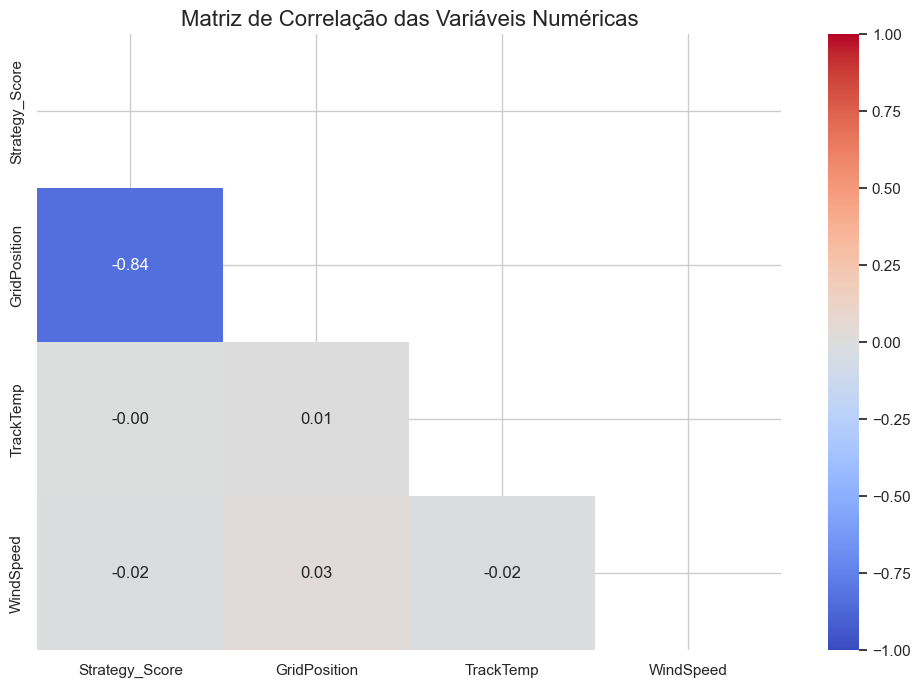

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

numerical_vars_for_corr = [
    'Strategy_Score',
    'GridPosition',
    'TrackTemp',
    'WindSpeed'
]

df_corr = df_top5_strategies_only[numerical_vars_for_corr].copy()

corr_matrix = df_corr.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix, 
    mask=mask, 
    annot=True,      
    cmap='coolwarm',    
    vmin=-1,          
    vmax=1,         
    fmt='.2f'       
)

plt.title('Matriz de Correlação das Variáveis Numéricas', fontsize=16)
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_strategy_score_bars_by_strategy(year, gp_name, merged_data):
    """
    Plota um gráfico de barras mostrando o Strategy Score de cada piloto,
    com cores baseadas na estratégia de pneus utilizada.
    (Versão corrigida para não mostrar o texto '0.00')
    """
    df_plot_data = merged_data[(merged_data['Year'] == year) & (merged_data['Race'] == gp_name)].copy()

    if df_plot_data.empty:
        print(f"Nenhum dado encontrado para {year} - {gp_name}")
        return

    df_plot_data = df_plot_data.sort_values(by='FinalPosition')

    plt.figure(figsize=(8, 4))
    
    barplot = sns.barplot(
        x='Driver', 
        y='Strategy_Score', 
        data=df_plot_data,
        hue='Strategy',
        palette='tab20',
        dodge=False
    )

    for p in barplot.patches:
        height = p.get_height()
        if abs(height) > 0.01:
            barplot.annotate(format(height, '.2f'), 
                           (p.get_x() + p.get_width() / 2., height), 
                           ha = 'center', va = 'center', 
                           xytext = (0, 9), 
                           textcoords = 'offset points')

    plt.axhline(0, color='black', lw=0.8)
    plt.title(f'Strategy Score por Piloto - {gp_name} {year}', fontsize=18, fontweight='bold')
    plt.xlabel('Piloto (ordenado por Posição Final)', fontsize=14)
    plt.ylabel('Strategy Score', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Estratégia')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_strategy_score_bars_by_strategy(2025, 'Japanese Grand Prix', df_top5_strategies_only)


top_n = 15
strategy_counts = df_model_final['Strategy'].value_counts().nlargest(top_n)

plt.figure(figsize=(8, 4))
sns.barplot(x=strategy_counts.values, y=strategy_counts.index, palette='viridis', orient='h')

plt.title(f'Top {top_n} Estratégias de Pneus Mais Utilizadas', fontsize=16)
plt.xlabel('Número de Vezes Utilizada (Frequência)', fontsize=12)
plt.ylabel('Estratégia (Sequência de Compostos)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

for index, value in enumerate(strategy_counts.values):
    plt.text(value, index, f' {value}', va='center')

plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.barplot(
    x='NumStops', 
    y='Strategy_Score', 
    data=df_model_final[df_model_final['NumStops'] <= 3],
    palette='plasma',
    errorbar='ci'
)

plt.title('Média do Strategy Score por Número de Paradas', fontsize=16)
plt.xlabel('Número de Paradas (Stops)', fontsize=12)
plt.ylabel('Média do Strategy Score', fontsize=12)
plt.show()

### English
<img src="https://flagcdn.com/w40/gb.png" width="30">

## 6. Final Conclusions

This project aimed to create a quantitative model to evaluate the efficiency of tire strategies in Formula 1 using public data. Through an iterative modeling process, we arrived at a final Ordinary Least Squares (OLS) model that proved to be statistically robust and highly predictive, explaining approximately **72% of the variance** in our `Strategy Score` metric.

The main conclusions of the study were:
1.  **Grid Position is the Dominant Factor:** Across all tested models, `GridPosition` was confirmed as the variable with the greatest impact, validating its crucial importance to the final race result.
2.  **The Ideal Strategy is Contextual:** The analysis revealed that there is no single "best strategy." The model identified that for the hard-compound tracks (Group 1), the key to success lies in **decisions made in the middle of the race**, such as the tire choice for the third stint.
3.  **The Model as a Simulation Tool:** The final application of the model as a simulator proved effective, capable of ranking hypothetical strategies and generating insights that reflect the nuances of different circuits.

In summary, the project demonstrated that it is possible, with an accessible approach and public data, to create a statistical model that not only predicts results but also offers valuable insights into the complex art of strategy in Formula 1.

---

### Português (BR)
<img src="https://flagcdn.com/w40/br.png" width="30">

## 6. Conclusões Finais

Este projeto se propôs a criar um modelo quantitativo para avaliar a eficiência de estratégias de pneus na Fórmula 1 utilizando dados públicos. Através de um processo iterativo de modelagem, chegamos a um modelo final de Regressão Linear (OLS) que se mostrou estatisticamente robusto e com alto poder preditivo, explicando aproximadamente **72% da variação** na nossa métrica de `Strategy Score`.

As principais conclusões do estudo foram:
1.  **A Posição de Largada é o Fator Dominante:** Em todos os modelos testados, a `GridPosition` se confirmou como a variável de maior impacto, validando sua importância crucial para o resultado final de uma corrida.
2.  **A Estratégia Ideal é Contextual:** A análise revelou que não existe uma única "melhor estratégia". O modelo identificou que, para as pistas de compostos duros (Grupo 1), a chave para o sucesso está nas **decisões tomadas no meio da corrida**, como a escolha do pneu para o terceiro stint.
3.  **O Modelo como Ferramenta de Simulação:** A aplicação final do modelo como um simulador se mostrou eficaz, sendo capaz de ranquear estratégias hipotéticas e gerar insights que refletem as nuances de diferentes circuitos.

Em suma, o trabalho demonstrou que é possível, com uma abordagem acessível e dados públicos, criar um modelo estatístico que não apenas prevê resultados, mas também oferece insights valiosos sobre a complexa arte da estratégia na Fórmula 1.